In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("/Volumes/ExtraHDD2/DS_Assignments_Data/ADM_2")

In [6]:
# Read the datasets
# Also converting the column cts in posters to date/time type. This will be useful also for later stages
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", parse_dates=[5])
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")
locations = pd.read_csv("instagram_locations.csv", delimiter="\t")

In [27]:
# RQ1 - Basic EDA [H1]
# Let's start with a *very* basic summary of the features of the datasets. On a very coarse level of analysis, we can check the number of observations in each dataset. _Posts is definitely the bigger one (challenging especially for our memory), with 42'710'197 observations, followed by _profiles_ (with 4'509'586 observations) and _locations_ (with 1'022'658 observations).
# This makes sense considering that for every profile there will be n posts and considering that locations get repeated a lot among posts, with many posts not even having any location. Specifically, to prove the point, locations repeat on average 17 times in the _post_ dataset and there are 12'972'772 posts without locations as can be seen in the code.

# Number of observations for dataset
print(f"Number of obs posts:{len(posts)}")
print(f"Number of obs profiles: {len(profiles)}")
print(f"Number of obs locations: {len(locations)}")

# Number of non-complete observations for dataset
# Is null returns a dataframe of booleans (na or not for each entry). Any returns true for each row (axis=1) which has a true value (a na field) and sums over the booleans, considering False as 0 and True as 1. This is a solution which is more elegant with respect to others.
print(f"Number of non-complete rows in posts: {posts.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in profiles: {profiles.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in locations: {locations.isnull().any(axis=1).sum()}")

# Number of posts without locations
print("Number of posts without locations: {}".format(posts["location_id"].isnull().sum()))
# Mean number of posts for each location (2 decimal digits)
print("Mean number of repetitions for each location: {}".format(round(posts["location_id"].value_counts().mean())))

# obs posts:42710197
# obs profiles: 4509586
# obs locations: 1022658
# non-complete rows in posts: 16280069
# non-complete rows in profiles: 3763522
# non-complete rows in locations: 1022658
# of posts without locations: 12972772
Mean number of repetitions for each location: 17


In [18]:
# Features of the post dataset [H2]

print(posts.columns.values)

# Basic summary statistics for posts
print(posts.describe().iloc[1:, 5:])

# Plot the # of posts for day of week
number_of_weeks = len(posts["cts"].dt.isocalendar().iloc[:, 0:2].drop_duplicates())
grouped_dayweek_post = posts.groupby(posts["cts"].dt.dayofweek)
week_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
count_week = grouped_dayweek_post["sid"].count().set_axis(week_list)

['sid' 'sid_profile' 'post_id' 'profile_id' 'location_id' 'cts'
 'post_type' 'description' 'numbr_likes' 'number_comments']
       numbr_likes  number_comments
mean  2.835030e+02         7.595308
std   6.124611e+03       194.147640
min   0.000000e+00         0.000000
25%   2.000000e+01         0.000000
50%   4.600000e+01         2.000000
75%   1.140000e+02         5.000000
max   8.822952e+06    488953.000000


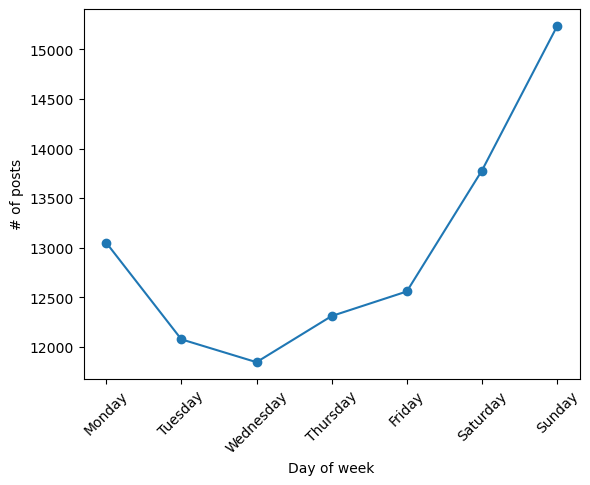

In [19]:
# This normalizes the number of posts giving us the mean number post for each day (across the years)
count_week /= number_of_weeks
count_week.plot(marker="o")
plt.xlabel("Day of week")
plt.ylabel("# of posts")
plt.xticks(rotation=45)
plt.show()

In [62]:
# Features of the post dataset [H2]
print(profiles.columns.values)

# Basic summary statistics for profiles
profiles.describe().iloc[1:, 2:].drop("min", axis = 0)

['sid' 'profile_id' 'profile_name' 'firstname_lastname' 'description'
 'following' 'followers' 'n_posts' 'url' 'cts' 'is_business_account']


,following,followers,n_posts
mean,1.405641e+03,4.739899e+03,409.541377
std,8.113473e+03,1.939087e+05,1041.940409
25%,3.560000e+02,1.590000e+02,22.000000
50%,7.540000e+02,4.060000e+02,120.000000
75%,1.573000e+03,9.740000e+02,420.000000
max,4.191080e+06,2.854576e+08,183730.000000


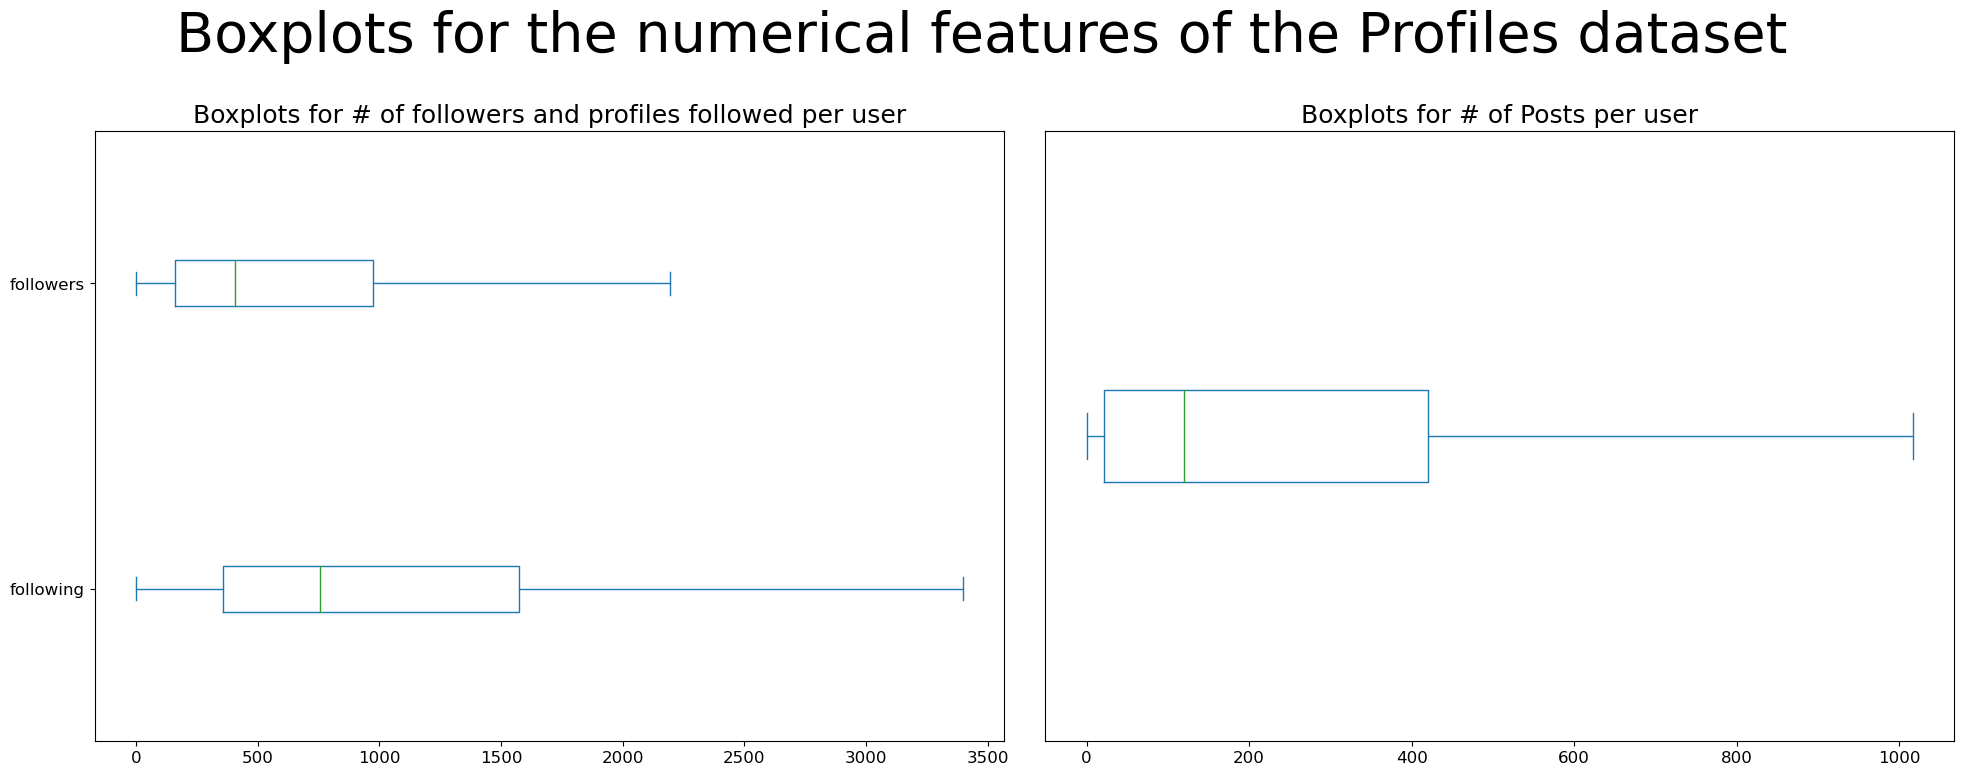

In [61]:
# Boxplots of numerical features in profiles

plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
profiles[["following", "followers"]].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.set_title("Boxplots for # of followers and profiles followed per user", {"fontsize":18})
ax = plt.subplot(1, 2, 2)
profiles["n_posts"].plot.box(showfliers=False, ax = ax, vert = False, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplots for # of posts per user", {"fontsize":18})
plt.suptitle("Boxplots for the numerical features of the profiles dataset", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()